# 🏠 House Prices: Advanced Regression & Model Stacking

Predicting house prices is a classic machine-learning problem, but solving it well requires more than fitting a single model and hoping for the best.

This notebook is designed as a **guided case study** that walks through a complete, real-world regression workflow using the *House Prices* dataset.

Rather than chasing leaderboard tricks, the goal here is to **build intuition** around:

- how different models behave,

- why feature engineering matters,

- and how multiple models can complement each other through stacking.

### What this notebook focuses on

We will progressively move from raw data to a strong ensemble model by covering:

- **Exploratory Data Analysis (EDA)** :- Understanding price distributions, important features, and data quirks

- **Thoughtful data cleaning** :- Handling missing values based on domain meaning (not blindly filling with zero)

- **Feature engineering** :- Creating house age, size, interaction, and quality-based features that models can learn from

- **Tree-based models** :- Training strong learners like CatBoost and LightGBM, each with different inductive biases

- **Cross-validation** :- Measuring performance reliably instead of trusting a single train/validation split

- **Model stacking** :- Combining multiple models using a meta-learner to capture complementary patterns

- **Conclusion & Key Inferences** :- Understanding why stacking helps and what conclusions we can draw from the results

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Import Libraries

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

from scipy.stats import rankdata

import lightgbm as lgb
from catboost import CatBoostRegressor

sns.set_style("whitegrid")

## Load the Data

In [17]:
train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)
train_df.head()

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The training data includes the target variable `SalePrice`.
The test data does not — this is what we will predict.

## Exploratory Data Analysis (EDA)

We begin by understanding the target variable: **SalePrice**.

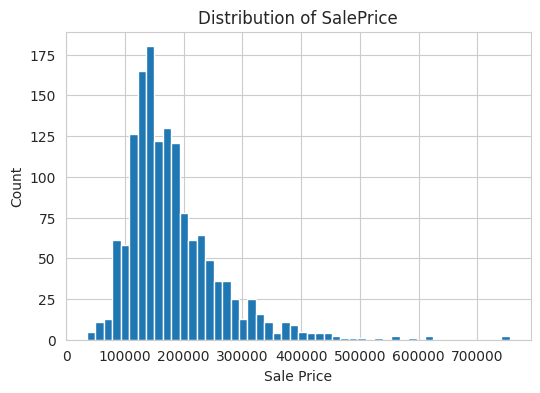

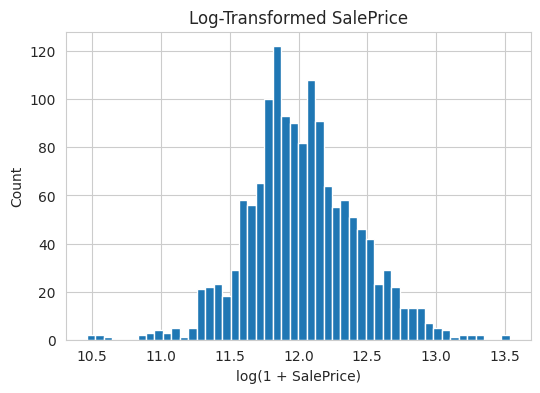

In [18]:
plt.figure(figsize=(6,4))
plt.hist(train_df["SalePrice"], bins=50)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.title("Distribution of SalePrice")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(np.log1p(train_df["SalePrice"]), bins=50)
plt.xlabel("log(1 + SalePrice)")
plt.ylabel("Count")
plt.title("Log-Transformed SalePrice")
plt.show()

House prices are **right-skewed**.
Using a log transform stabilises training and improves performance.

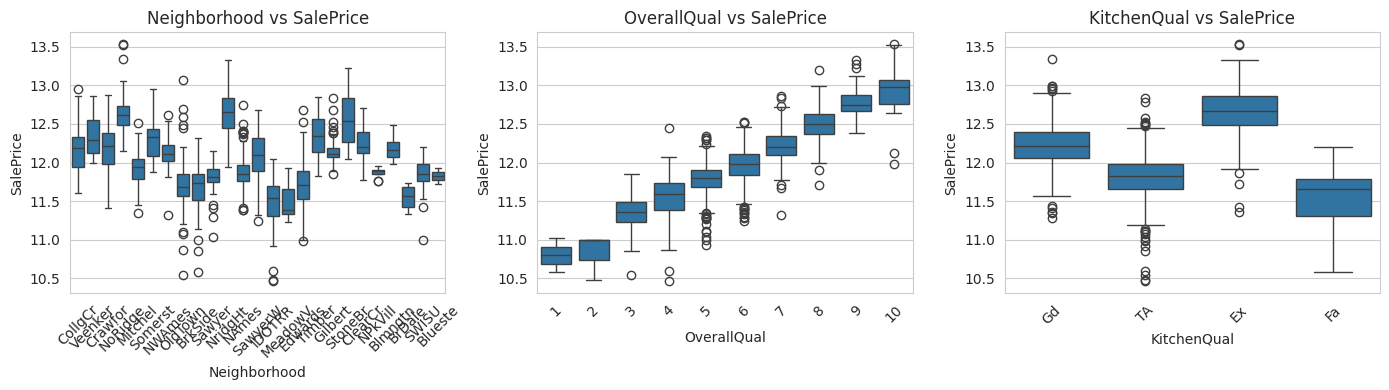

In [19]:

top_cats = ["Neighborhood", "OverallQual", "KitchenQual"]

plt.figure(figsize=(14,4))
for i, col in enumerate(top_cats, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(
        x=train_df[col],
        y=np.log1p(train_df["SalePrice"])
    )
    plt.title(f"{col} vs SalePrice")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

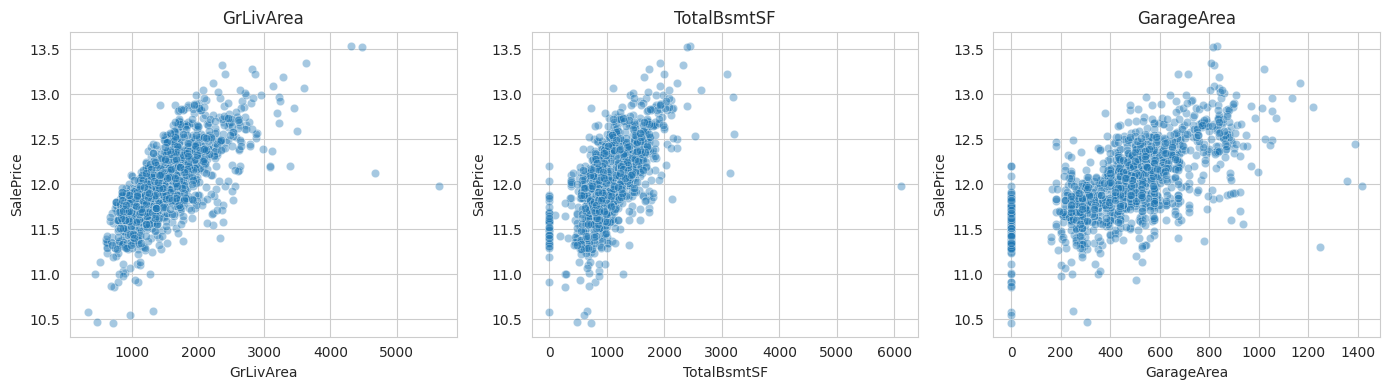

In [20]:
features = ["GrLivArea", "TotalBsmtSF", "GarageArea"]

plt.figure(figsize=(14,4))
for i, col in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        x=train_df[col],
        y=np.log1p(train_df["SalePrice"]),
        alpha=0.4
    )
    plt.title(col)

plt.tight_layout()
plt.show()

### EDA: Key Relationships

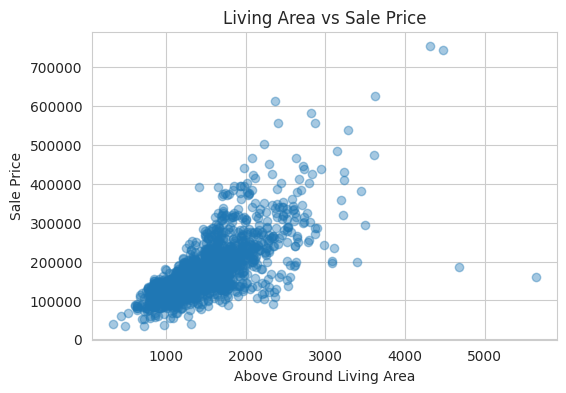

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(train_df["GrLivArea"], train_df["SalePrice"], alpha=0.4)
plt.xlabel("Above Ground Living Area")
plt.ylabel("Sale Price")
plt.title("Living Area vs Sale Price")
plt.show()

Larger houses generally sell for more, but not perfectly linearly.

## Feature Engineering

Raw features are often not ideal for models.

We create **new features** that better capture real-world meaning:
- How old is the house?
- How much total living space is there?
- How many bathrooms are there in total?

In [22]:
def add_features(df):
    df["TotalSF"] = df["GrLivArea"] + df["TotalBsmtSF"] + df["GarageArea"]
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["IsRemodeled"] = (df["YearBuilt"] != df["YearRemodAdd"]).astype(int)
    df["Qual_SF"] = df["OverallQual"] * df["GrLivArea"]
    df["Log_GrLivArea"] = np.log1p(df["GrLivArea"])
    df["Garage_Area_per_Car"] = df["GarageArea"] / (df["GarageCars"] + 1)
    return df


In [23]:
train_df = add_features(train_df)
test_df  = add_features(test_df)

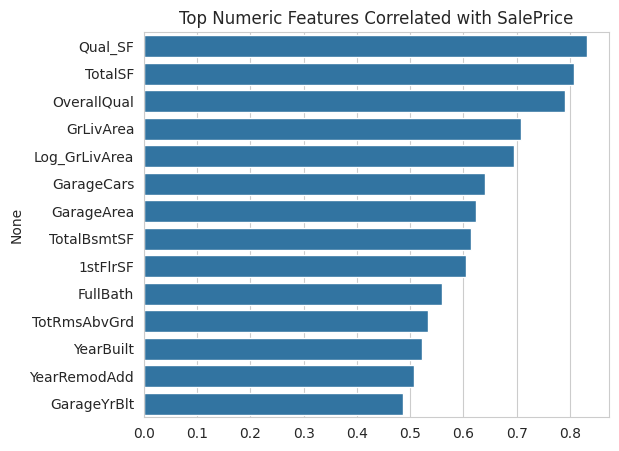

In [24]:
corr = train_df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)

top_corr = corr[1:15]

plt.figure(figsize=(6,5))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top Numeric Features Correlated with SalePrice")
plt.show()

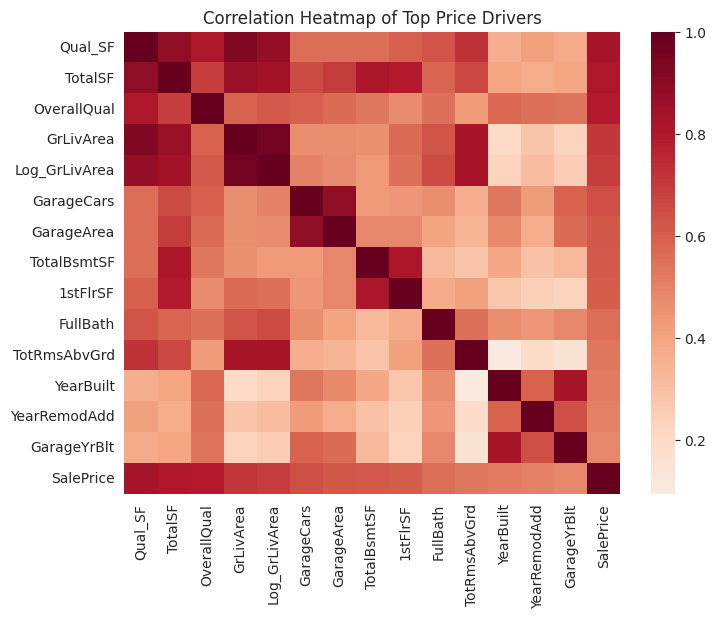

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(
    train_df[top_corr.index.tolist() + ["SalePrice"]].corr(),
    cmap="RdBu_r",
    center=0,
    annot=False
)
plt.title("Correlation Heatmap of Top Price Drivers")
plt.show()

## Handling Missing Values Correctly

Different columns represent different things.

Numeric features → fill with **median**  
Categorical features → fill with **"None"**

In [26]:
#drop_cols = ["Utilities", "Street", "Condition2", "RoofMatl", "MiscFeature"]

#train_df.drop(columns=drop_cols, inplace=True)
#test_df.drop(columns=drop_cols, inplace=True)

In [27]:
num_cols = train_df.drop("SalePrice", axis=1)\
                   .select_dtypes(include=["int64", "float64"]).columns

cat_cols = train_df.select_dtypes(include=["object"]).columns

for col in num_cols:
    med = train_df[col].median()
    train_df[col] = train_df[col].fillna(med)
    test_df[col]  = test_df[col].fillna(med)

for col in cat_cols:
    train_df[col] = train_df[col].fillna("None")
    test_df[col]  = test_df[col].fillna("None")

## Ordinal Encoding

Some categorical features have an **order**:
Poor < Fair < Typical < Good < Excellent

We convert them into numbers so models understand the ranking.

In [28]:
qual_map = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}

for col in ["ExterQual","KitchenQual","HeatingQC","GarageQual","BsmtQual"]:
    train_df[col+"_Ord"] = train_df[col].map(qual_map)
    test_df[col+"_Ord"]  = test_df[col].map(qual_map)

#bsmt_map = {"None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
#train_df["BsmtExposure"] = train_df["BsmtExposure"].map(bsmt_map)
#test_df["BsmtExposure"]  = test_df["BsmtExposure"].map(bsmt_map)
bsmt_map = {
    "None": 0,
    "No": 1,
    "Mn": 2,
    "Av": 3,
    "Gd": 4
}
train_df["BsmtExposure"] = train_df["BsmtExposure"].map(bsmt_map).fillna(0)
test_df["BsmtExposure"]  = test_df["BsmtExposure"].map(bsmt_map).fillna(0)

## Target Variable

House prices are skewed.

We apply a log transformation to stabilize training.

In [29]:
y = np.log1p(train_df["SalePrice"])

## Why Multiple Models?

Different models learn different patterns:

- **CatBoost**: excellent with categorical data
- **LightGBM**: very strong with numeric interactions

We train **two versions of each**:
- One flexible (can overfit)
- One conservative (more regularised)

This creates **diversity**, which is essential for stacking.

### CatBoost (raw categoricals)

In [30]:
X_cat = train_df.drop("SalePrice", axis=1)
test_X_cat = test_df.copy()

#cat_features = X_cat.select_dtypes(include=["object"]).columns
#cat_idx = [X_cat.columns.get_loc(c) for c in cat_features]

### LightGBM (one-hot)

In [31]:
X_lgb = pd.get_dummies(X_cat)
test_X_lgb = pd.get_dummies(test_X_cat)

X_lgb, test_X_lgb = X_lgb.align(
    test_X_lgb, join="left", axis=1, fill_value=0
)

## Cross-Validation & OOF Predictions

To stack models correctly, we use **Out-Of-Fold (OOF) predictions**.

Each model:
- Trains on part of the data
- Predicts on unseen data
- These predictions become inputs to the meta-model

In [32]:
N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

## Base Models

In [33]:
cat_a = CatBoostRegressor(
    iterations=7000,
    learning_rate=0.02,
    depth=7,
    l2_leaf_reg=2,
    loss_function="RMSE",
    random_seed=42,
    early_stopping_rounds=400,
    verbose=0
)

In [34]:
cat_b = CatBoostRegressor(
    iterations=6000,
    learning_rate=0.02,
    depth=5,
    l2_leaf_reg=6,
    loss_function="RMSE",
    random_seed=42,
    early_stopping_rounds=400,
    verbose=0
)

In [35]:
lgb_a = lgb.LGBMRegressor(
    n_estimators=8000,
    learning_rate=0.01,
    num_leaves=128,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

In [36]:
lgb_b = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.01,
    num_leaves=32,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=0.3,
    random_state=42,
    verbose=-1
)

## Rank-Based Stacking

Instead of combining raw predictions,
we combine **prediction rankings**.

This focuses on:
✔ Which house is more expensive than another  
✔ Reduces noise  
✔ Often improves leaderboard generalisation

In [37]:
oof_cat_a = np.zeros(len(X_cat))
oof_cat_b = np.zeros(len(X_cat))
oof_lgb_a = np.zeros(len(X_cat))
oof_lgb_b = np.zeros(len(X_cat))

test_cat_a = np.zeros(len(test_X_cat))
test_cat_b = np.zeros(len(test_X_cat))
test_lgb_a = np.zeros(len(test_X_lgb))
test_lgb_b = np.zeros(len(test_X_lgb))

In [38]:
cat_features = X_cat.select_dtypes(include=["object"]).columns.tolist()
cat_idx = [X_cat.columns.get_loc(c) for c in cat_features]

print("Number of categorical features:", len(cat_idx))

Number of categorical features: 42


In [39]:
for fold, (trn, val) in enumerate(kf.split(X_cat)):
    print(f"Fold {fold + 1}")

    X_tr_cat, X_val_cat = X_cat.iloc[trn], X_cat.iloc[val]
    X_tr_lgb, X_val_lgb = X_lgb.iloc[trn], X_lgb.iloc[val]
    y_tr, y_val = y.iloc[trn], y.iloc[val]

    # CatBoost A
    cat_a.fit(X_tr_cat, y_tr, eval_set=(X_val_cat, y_val), cat_features=cat_idx)
    oof_cat_a[val] = cat_a.predict(X_val_cat)
    test_cat_a += cat_a.predict(test_X_cat) / N_FOLDS

    # CatBoost B
    cat_b.fit(X_tr_cat, y_tr, eval_set=(X_val_cat, y_val), cat_features=cat_idx)
    oof_cat_b[val] = cat_b.predict(X_val_cat)
    test_cat_b += cat_b.predict(test_X_cat) / N_FOLDS

    # LightGBM A
    lgb_a.fit(X_tr_lgb, y_tr)
    oof_lgb_a[val] = lgb_a.predict(X_val_lgb)
    test_lgb_a += lgb_a.predict(test_X_lgb) / N_FOLDS

    # LightGBM B
    lgb_b.fit(X_tr_lgb, y_tr)
    oof_lgb_b[val] = lgb_b.predict(X_val_lgb)
    test_lgb_b += lgb_b.predict(test_X_lgb) / N_FOLDS

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


### Model Comparison Visualisation

Cat A: 0.12009996327305598
Cat B: 0.12250086491101059
LGB A: 0.1309601190473318
LGB B: 0.129782787632755


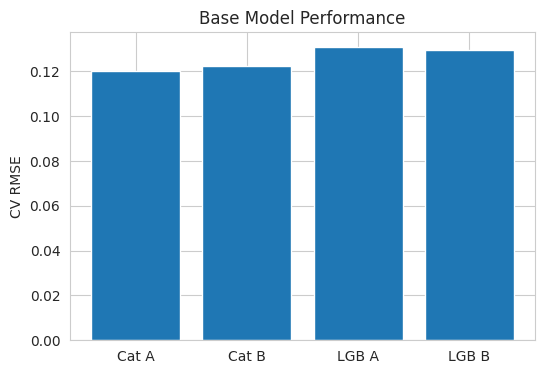

In [40]:
def rmse(y, oof):
    return np.sqrt(mean_squared_error(y, oof))

print("Cat A:", rmse(y, oof_cat_a))
print("Cat B:", rmse(y, oof_cat_b))
print("LGB A:", rmse(y, oof_lgb_a))
print("LGB B:", rmse(y, oof_lgb_b))

scores = [
    rmse(y, oof_cat_a),
    rmse(y, oof_cat_b),
    rmse(y, oof_lgb_a),
    rmse(y, oof_lgb_b),
]

labels = ["Cat A", "Cat B", "LGB A", "LGB B"]

plt.figure(figsize=(6,4))
plt.bar(labels, scores)
plt.ylabel("CV RMSE")
plt.title("Base Model Performance")
plt.show()

Combining models reduces error by leveraging complementary strengths.

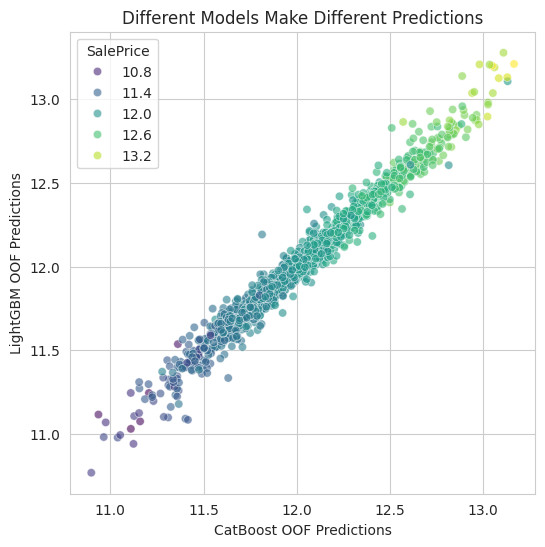

In [41]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=oof_cat_a,
    y=oof_lgb_a,
    hue=y,
    palette="viridis",
    alpha=0.6
)
plt.title("Different Models Make Different Predictions")
plt.xlabel("CatBoost OOF Predictions")
plt.ylabel("LightGBM OOF Predictions")
plt.show()

Models disagree — stacking learns how to combine them.

### Rank-Based Stacking

In [42]:
stack_X_train = np.column_stack([
    oof_cat_a,
    oof_cat_b,
    oof_lgb_a,
    oof_lgb_b
])

stack_X_test = np.column_stack([
    test_cat_a,
    test_cat_b,
    test_lgb_a,
    test_lgb_b
])

In [43]:
scaler = StandardScaler()

stack_X_train_scaled = scaler.fit_transform(stack_X_train)
stack_X_test_scaled  = scaler.transform(stack_X_test)

meta = ElasticNet(
    alpha=0.0003,
    l1_ratio=0.3,
    random_state=42
)

meta.fit(stack_X_train_scaled, y)

print("Meta weights:", meta.coef_)

oof_stack = meta.predict(stack_X_train_scaled)
print("STACK CV RMSE:", np.sqrt(mean_squared_error(y, oof_stack)))

final_preds = np.expm1(meta.predict(stack_X_test_scaled))

Meta weights: [0.26550351 0.04634087 0.05252038 0.0175451 ]
STACK CV RMSE: 0.11926542971398887


In [44]:
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": final_preds
})

submission.to_csv("submission.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,120242.149026
1,1462,159130.316837
2,1463,182450.127817
3,1464,191057.973597
4,1465,183921.778849


## Conclusion & Key Inferences

In this notebook, we walked through a complete machine learning workflow
for a real-world regression problem.

Rather than focusing on a single model, we explored **how different models
learn different aspects of the same data**, and how combining them can
lead to stronger, more reliable predictions.

From this exercise, we can draw several important inferences:

### 1. Feature engineering is foundational  
Models perform best when the input features reflect **real-world meaning**.
Creating features such as house age, total living area, and combined
bathroom counts helps models learn relationships that raw data cannot
express directly.

### 2. No single model is universally best  
Different algorithms excel at different tasks:
- Some handle categorical information naturally
- Others are better at capturing numeric interactions

Understanding model strengths is more important than choosing a “popular”
algorithm.

### 3. Diversity enables improvement  
Stacking works only when models make **different kinds of mistakes**.
Training multiple versions of similar models with different settings
creates useful diversity that a meta-model can learn from.

### 4. Cross-validation simulates real-world performance  
By using out-of-fold predictions, we ensured that every evaluation step
was performed on unseen data. This closely mirrors how models behave when
deployed in practice.

### 5. Ensembles reflect real decision-making  
In many real-world systems, decisions are not made by a single expert.
Instead, they combine multiple opinions and weigh them appropriately.
Model stacking follows the same principle.

---

### Final Thoughts

Machine learning is not about finding one perfect model.
It is about **building systems that learn from data in complementary ways**.

The techniques shown here — feature engineering, cross-validation,
and stacking — form a strong foundation for tackling more complex
regression problems beyond this dataset.
